# Artifact Removal techniques

### $\bullet$ $\textbf{Signal Processing techniques}$

##### $\rightarrow$ Independant Component Analysis (ICA) 

Independent Component Analysis (ICA) is a technique used to separate a multivariate signal into independent, non-Gaussian sources. It is a generalization of Principal Component Analysis (PCA) and it is used in many fields such as signal processing, machine learning, and neuroscience. ICA can be used to remove noise, extract features, and separate independent sources from a mixed signal. $\textbf{\textit{number of sources must be known}}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from utils.kouzina import *
from utils.handytools import *
import mne

In [2]:
df = edf2csv('Data/PN17-2.edf').to_data_frame()
df.columns

Extracting EDF parameters from /home/baki/Desktop/working/Data/PN17-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Index(['time', 'EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7',
       'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9',
       'EEG Fz', 'EEG Pz', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8',
       'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6',
       'EEG F10', 'SPO2', 'HR', '1', '2', 'EEG FP2', 'EEG P9', 'EEG P10',
       'PLET', '61', '62', '63', '64', 'EEG T3', 'EEG CZ', '3', '23', '33',
       '31', 'A', 'B', 'C', 'D', 'MK'],
      dtype='object')

In [3]:
eegset = df.loc[:, ['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7',
       'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9',
       'EEG Fz', 'EEG Pz', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8',
       'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6','EEG F10','EEG FP2','EEG P9', 'EEG P10','EEG T3', 'EEG CZ']]
len(eegset.columns)

31

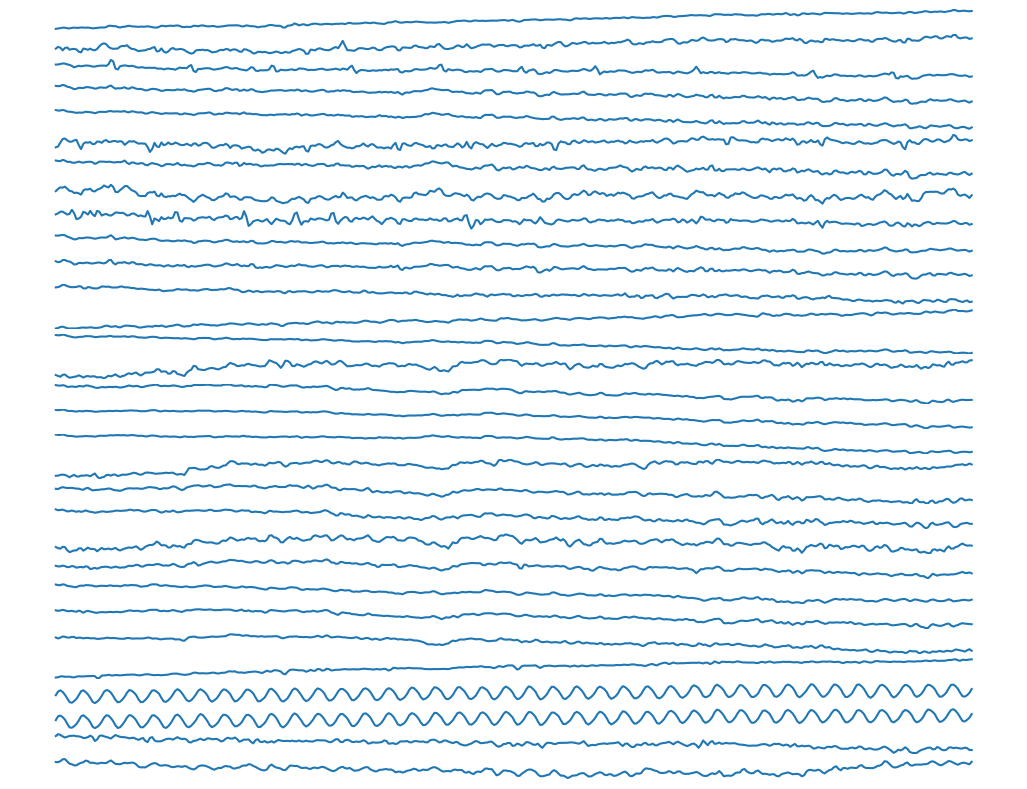

In [4]:
fig, axs = plt.subplots(31,1)
fig.set_size_inches(13, 10)
columns = eegset.columns
for i in range(len(columns)):
    axs[i].plot(eegset[columns[i]][1000:1400],label='IC'+str(i))  
    axs[i].axis('off') 
plt.show()

In [5]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=31, random_state=42)
S_ = ica.fit_transform(eegset)
S = S_.T

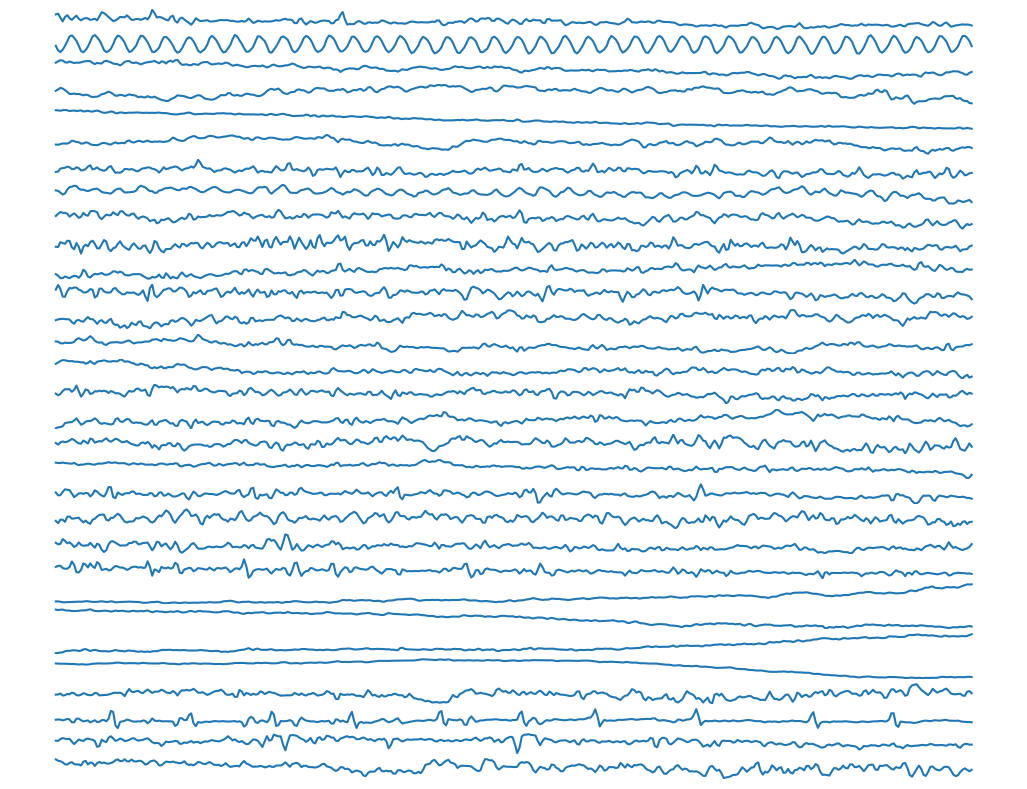

In [6]:
fig, axs = plt.subplots(31,1)
fig.set_size_inches(13, 10)
for i in range(31):
    axs[i].plot(S[i][1000:1400],label='IC'+str(i))  
    axs[i].axis('off') 
plt.show()

### $\bullet$ $\textbf{Generative AI techniques}$

#### $\bullet$ Generative AI

##### $\rightarrow$ RNN Network

Here we use sitting ECG signals to RNN network, then try to generate for running sampels

In [20]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, mean
from scipy.signal import butter, freqz
from scipy.fftpack import fft
import os
from tensorflow import keras
import datetime
import scipy.io.wavfile
from scipy.interpolate import splrep, splev
import io
from keras import regularizers

In [4]:
df = pd.read_csv('PPG_DATA/physionet.org/files/pulse-transit-time-ppg/1.0.0/csv/s1_sit.csv')

In [14]:
ecg = preprocessing.normalize([df['ecg']]).T

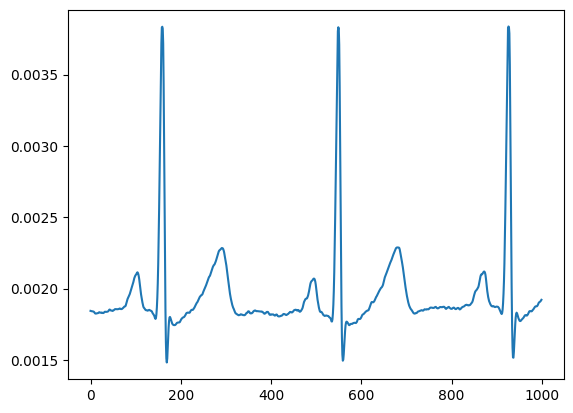

In [18]:
plt.plot(ecg[:1000])

In [21]:
def split_input_target(chunk):
  input = chunk[:-1]
  target = chunk[1:]
  return input, target

def build_model(numUniqueCharacters, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(numUniqueCharacters, embedding_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',stateful=True), #,recurrent_regularizer = keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',stateful=True), #,recurrent_regularizer = keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.GRU(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',stateful=True), #,recurrent_regularizer = keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
  tf.keras.layers.Dense(numUniqueCharacters)
])
  return model

def loss(labels, logits):
  return keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


Text(0.5, 1.0, 'Input signal')

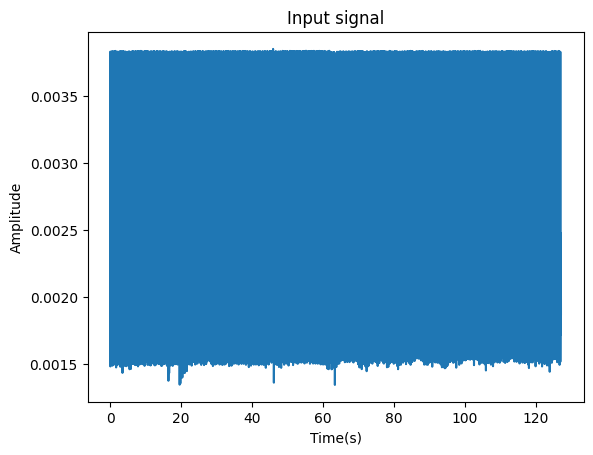

In [24]:
fs = 2000
x = np.asarray(ecg)

lenx = np.size(x)
t_input = np.linspace(0, lenx/fs, lenx)

# Visualize the generated motion artifact signal over time
plt.plot(t_input, x)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Input signal')

In [25]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

In [26]:
# Setting standard filter requirements.

# Specify the order of the lowpass filter
order = 6
# Specify the cutoff frequency for the lowpass filter
cutoff = 10

y = butter_lowpass_filter(x, cutoff, fs, order)

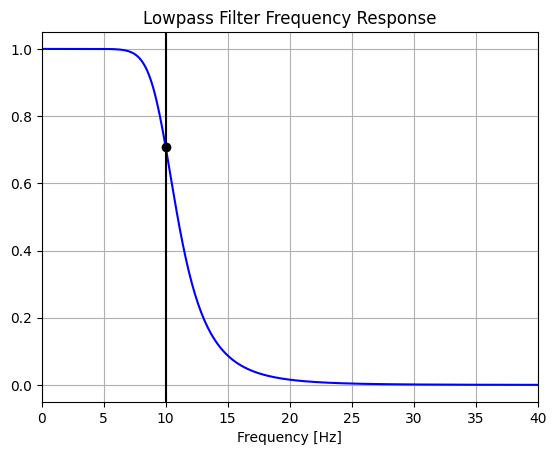

In [27]:
b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response of the lowpass filter.
w, h = freqz(b, a, worN=8000)
#plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 40)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [28]:
signal_power = np.sum(np.square(y))/len(y)
z = y/np.sqrt(signal_power)

In [30]:
new_fs = 67
down_factor = fs/new_fs
data = signal.resample(z, int(len(z)/down_factor))

In [31]:
def find_psd(z, new_fs):
    f, Pxx_den = signal.welch(z, fs = new_fs, nperseg = len(z)/5)
    return(Pxx_den,f)

pxx, f = find_psd(data, new_fs)

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1701 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


In [33]:
S_d = 64
x_min = np.min(data)
x_max = np.max(data)
x_q = np.round((data-x_min)/(x_max-x_min)*(S_d-1))
x_q = x_q.astype(int)

In [36]:
# =============================================================================
# Window size selection 
# =============================================================================
  
win_length = 500 #window size 
win_inc = 25 # window increment 

examples_per_epoch = np.size(data)//win_inc
dataset = tf.data.Dataset.from_tensor_slices(x_q)
test = dataset.window(size=win_length, shift=win_inc,stride=1,drop_remainder=True).flat_map(lambda x: x.batch(win_length))         
dataset_targets = test.map(split_input_target)

# =============================================================================
# Create training batches
# =============================================================================

# Batch size
BATCH_SIZE = 5
steps_per_epoch = examples_per_epoch//BATCH_SIZE

#shuffle inputs 
BUFFER_SIZE = 10000
dataset_train = dataset_targets.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# =============================================================================
# Parameters for RNN Structure
# =============================================================================

# Embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 256

# Define size of dense layer 
numUniqueCharacters = int(max(x_q))+1

# =============================================================================
# Build model
# =============================================================================
model = build_model(
  numUniqueCharacters = numUniqueCharacters,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(
    optimizer = optimizer,
    loss = loss,
    )

model.summary()

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) #add .hdf5 

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


/tmp/ipykernel_5665/3074743718.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  numUniqueCharacters = int(max(x_q))+1


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (5, None, 256)            16384     
                                                                 
 gru_6 (GRU)                 (5, None, 256)            394752    
                                                                 
 gru_7 (GRU)                 (5, None, 256)            394752    
                                                                 
 gru_8 (GRU)                 (5, None, 256)            394752    
                                                                 
 dense_2 (Dense)             (5, None, 64)             16448     
                                                                 
Total params: 1217088 (4.64 MB)
Trainable params: 1217088 (4.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
EPOCHS= 200
history = model.fit(dataset_train.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])               

Epoch 1/200


2024-02-19 17:49:03.976167: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


68/68 [==============================] - 6s 45ms/step - loss: 3.5397
Epoch 2/200
68/68 [==============================] - 3s 42ms/step - loss: 2.9325
Epoch 3/200
68/68 [==============================] - 3s 42ms/step - loss: 2.4980
Epoch 4/200
68/68 [==============================] - 3s 43ms/step - loss: 2.1591
Epoch 5/200
68/68 [==============================] - 3s 43ms/step - loss: 2.0170
Epoch 6/200
68/68 [==============================] - 3s 43ms/step - loss: 1.9344
Epoch 7/200
68/68 [==============================] - 3s 44ms/step - loss: 1.8426
Epoch 8/200
68/68 [==============================] - 3s 43ms/step - loss: 1.7711
Epoch 9/200
68/68 [==============================] - 3s 43ms/step - loss: 1.6930
Epoch 10/200
68/68 [==============================] - 3s 43ms/step - loss: 1.6248
Epoch 11/200
68/68 [==============================] - 3s 43ms/step - loss: 1.5644
Epoch 12/200
68/68 [==============================] - 3s 43ms/step - loss: 1.4970
Epoch 13/200
68/68 [=================

In [39]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(numUniqueCharacters, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

model.save('saved_model.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (1, None, 256)            16384     
                                                                 
 gru_12 (GRU)                (1, None, 256)            394752    
                                                                 
 gru_13 (GRU)                (1, None, 256)            394752    
                                                                 
 gru_14 (GRU)                (1, None, 256)            394752    
                                                                 
 dense_4 (Dense)             (1, None, 64)             16448     
                                                                 
Total params: 1217088 (4.64 MB)
Trainable params: 1217088 (4.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
from zipfile import ZipFile
from os.path import basename
with ZipFile('training_checkpoints.zip', 'w') as zipObj:
   for folderName, subfolders, filenames in os.walk('training_checkpoints'):
       for filename in filenames:
           filePath = os.path.join(folderName, filename)
           zipObj.write(filePath, basename(filePath))

In [49]:
model = tf.keras.models.load_model('saved_model.h5', compile=False)
#!unzip training_checkpoints.zip -d training_checkpoint
# Directory where the checkpoints are saved
checkpoint_dir = './training_checkpoint/'


model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [64]:
test = pd.read_csv('PPG_DATA/physionet.org/files/pulse-transit-time-ppg/1.0.0/csv/s15_run.csv')
target = preprocessing.normalize([test['ecg']]).T

In [77]:
target.shape

(247497, 1)

In [65]:
def generate_signal(model, start_seq, num_generate):
  input_eval = tf.expand_dims(start_seq, 0)
  signal_generated = np.asarray([])
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      temperature = 1
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      signal_generated=np.append(signal_generated, predicted_id)
  return (np.append(start_seq,signal_generated))


In [70]:
num_generate = 11598 # Number of samples to generate
output = generate_signal(model, start_seq= target[0:500], num_generate = num_generate)
output = np.asarray(output)

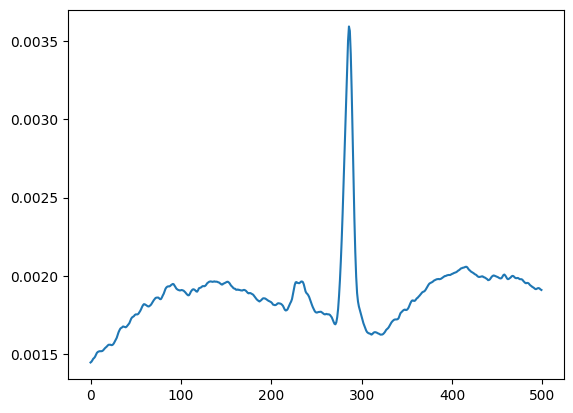

In [76]:
plt.plot(output[:500])

([<matplotlib.lines.Line2D at 0x7f54226411b0>],
 [<matplotlib.lines.Line2D at 0x7f5422641390>])

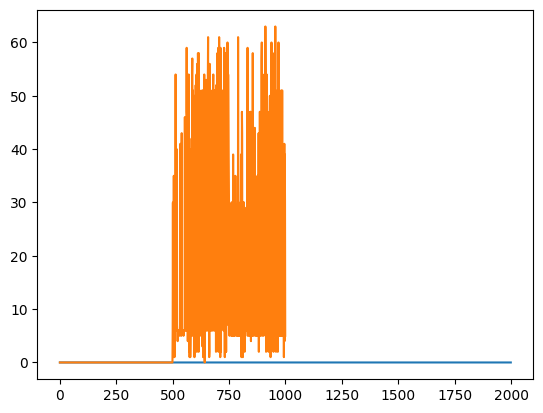

In [74]:
plt.plot(target[:2000]),plt.plot(output[:1000])

##### $\bullet$ VAE

We try to implement Variational auto-encoders on separating biomedical signals. [link1](file:///home/baki/Downloads/978-3-030-63007-2.pdf)

#### $\bullet$ Deep CNN

In [2]:
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

from EEG_cnn.model import *
from EEG_cnn.utils import *
from EEG_cnn.data_input import *

In [9]:
EEG = np.load('EEG_cnn/denoiseNET_dataset/EEG_artifacts.npy')
EOG = np.load('EEG_cnn/denoiseNET_dataset/EOG_artifacts.npy')
EMG = np.load('EEG_cnn/denoiseNET_dataset/EMG_artifacts.npy')

In [10]:
train_x_eog, train_y_eog, test_x_eog, test_y_eog, test_std_VALUE = data_prepare(EEG, EOG, combin_num, train_num, test_num)

train_x_emg, train_y_emg, test_x_emg, test_y_emg, test_std_VALUE = data_prepare(EEG, EMG, combin_num, train_num, test_num)

train_input = np.vstack((train_x_eog, train_x_emg))
train_output = np.vstack((train_y_eog, train_y_emg))
test_input = np.vstack((test_x_eog, test_x_emg))
test_output = np.vstack((test_y_eog, test_y_emg))

np.save('EEG_cnn/denoiseNET_dataset/train_input.npy', train_input)
np.save('EEG_cnn/denoiseNET_dataset/train_output.npy', train_output)
np.save('EEG_cnn/denoiseNET_dataset/test_input.npy', test_input)
np.save('EEG_cnn/denoiseNET_dataset/test_output.npy', test_output)

np.save('EEG_cnn/denoiseNET_dataset/EOG_EEG_test_input.npy', train_x_eog)
np.save('EEG_cnn/denoiseNET_dataset/EOG_EEG_test_output.npy', train_y_eog)
np.save('EEG_cnn/denoiseNET_dataset/EMG_EEG_test_input.npy', test_x_eog)
np.save('EEG_cnn/denoiseNET_dataset/EMG_EEG_test_output.npy', test_y_eog)

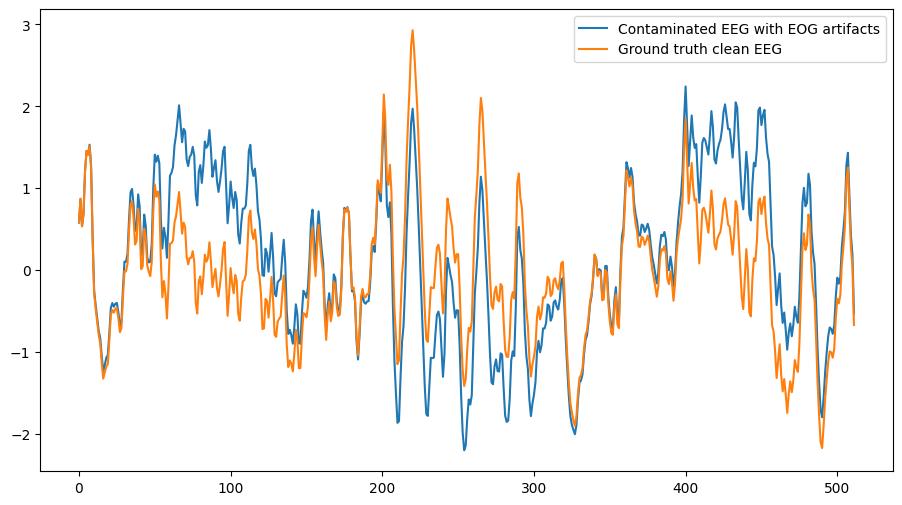

In [11]:
plt.figure(figsize=(11,6))
x1, = plt.plot(train_x_eog[0])
x2, = plt.plot(train_y_eog[0])
plt.legend([x1, x2], ['Contaminated EEG with EOG artifacts', 'Ground truth clean EEG'], loc='upper right')

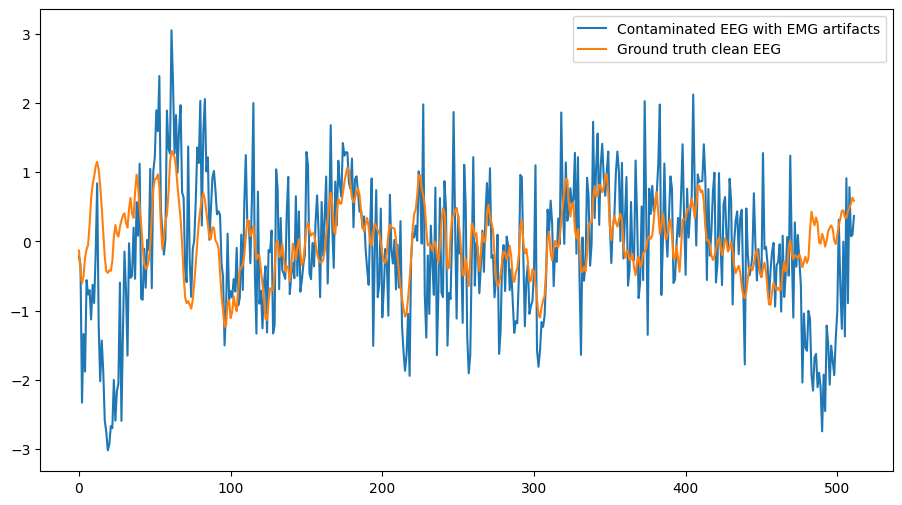

In [12]:
plt.figure(figsize=(11,6))
x1, = plt.plot(train_x_emg[2])
x2, = plt.plot(train_y_emg[2])
plt.legend([x1, x2], ['Contaminated EEG with EMG artifacts', 'Ground truth clean EEG'], loc='upper right')

In [2]:
raw_eeg = np.load('EEG_cnn/denoiseNET_dataset/train_input.npy',allow_pickle=True)
clean_eeg = np.load('EEG_cnn/denoiseNET_dataset/train_output.npy',allow_pickle=True)

artifact1 = np.load('EEG_cnn/denoiseNET_dataset/EOG_artifacts.npy',allow_pickle=True)
artifact2 = np.load('EEG_cnn/denoiseNET_dataset/EMG_artifacts.npy',allow_pickle=True)

test_input = np.load('EEG_cnn/denoiseNET_dataset/test_input.npy',allow_pickle=True)
test_output = np.load('EEG_cnn/denoiseNET_dataset/test_output.npy',allow_pickle=True)


In [3]:
artifact1 = standardization(artifact1)
artifact2 = standardization(artifact2)
artifact = np.concatenate((artifact1, artifact2), axis=0)

indicator1 = np.zeros(raw_eeg.shape[0])
indicator2 = np.ones(artifact.shape[0])
indicator3 = np.zeros(clean_eeg.shape[0])
indicator = np.concatenate((indicator1, indicator2, indicator3), axis=0)

train_input = np.concatenate((raw_eeg, artifact, clean_eeg), axis=0)
train_output = np.concatenate((clean_eeg, artifact, clean_eeg), axis=0)

indicator = torch.from_numpy(indicator)
indicator = indicator.unsqueeze(1)

train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_indicator = np.zeros(test_input.shape[0])
test_indicator = torch.from_numpy(test_indicator)
test_indicator = test_indicator.unsqueeze(1)

In [5]:
train_torch_dataset = Data.TensorDataset(train_input, indicator, train_output)
train_loader = Data.DataLoader(dataset=train_torch_dataset, batch_size=batch_size, shuffle=True)


test_torch_dataset = Data.TensorDataset(test_input, test_indicator, test_output)
test_loader = Data.DataLoader(dataset=test_torch_dataset, batch_size=batch_size, shuffle=False)

In [3]:
combin_num = 20
epochs = 10
batch_size = 1000 
train_num = 3000
test_num = 400
mini_loss = 1
print_loss_frequency = 1
print_train_accuracy_frequency = 1
test_frequency = 1

##### Training

In [22]:
model = deepCNN()
loss = nn.MSELoss(reduction='mean')
device = 'cuda:0'

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
if os.path.exists('EEG_cnn/checkpoint/' + str(deepCNN) + '.pkl'):
    print('load model')
    model.load_state_dict(torch.load('EEG_cnn/checkpoint/' + model_name + '.pkl'))

In [28]:
for epoch in range(epochs):

    train_acc = 0
    train_loss = 0

    total_train_loss_per_epoch = 0
    average_train_loss_per_epoch = 0
    train_step_num = 0

    for step, (train_input, indicator, train_output) in enumerate(train_loader):

        train_step_num += 1

        indicator = indicator.float().to(device)
        train_input = train_input.float().to(device)
        train_output = train_output.float().to(device)

        optimizer.zero_grad()

        train_preds = model(train_input, indicator)

        train_loss = loss(train_preds, train_output)

        total_train_loss_per_epoch += train_loss.item()

        train_loss.backward()
        optimizer.step()

    average_train_loss_per_epoch = total_train_loss_per_epoch / train_step_num

    if epoch % print_loss_frequency == 0:
        print('train loss: ', average_train_loss_per_epoch)

    test_step_num = 0
    total_test_loss_per_epoch = 0
    average_test_loss_per_epoch = 0

    if epoch % test_frequency == 0:

        for step, (test_input, test_indicator, test_output) in enumerate(test_loader):

            test_step_num += 1

            test_indicator = test_indicator.float().to(device)

            test_input = test_input.float().to(device)
            test_output = test_output.float().to(device)

            test_preds = model(test_input, test_indicator)

            test_loss = loss(test_preds, test_output)

            total_test_loss_per_epoch += test_loss.item()

        average_test_loss_per_epoch = total_test_loss_per_epoch / test_step_num

        print('--------------test loss: ', average_test_loss_per_epoch)

        if average_test_loss_per_epoch < mini_loss:
            print('save model')
            torch.save(model.state_dict(), 'EEG_cnn/checkpoint/' + model_name + '.pkl')
            mini_loss = average_test_loss_per_epoch

train loss:  0.06071348444943926
--------------test loss:  0.0889682644046843
save model


KeyboardInterrupt: 

##### Inference

torch.cuda.is_available() =  True
load model


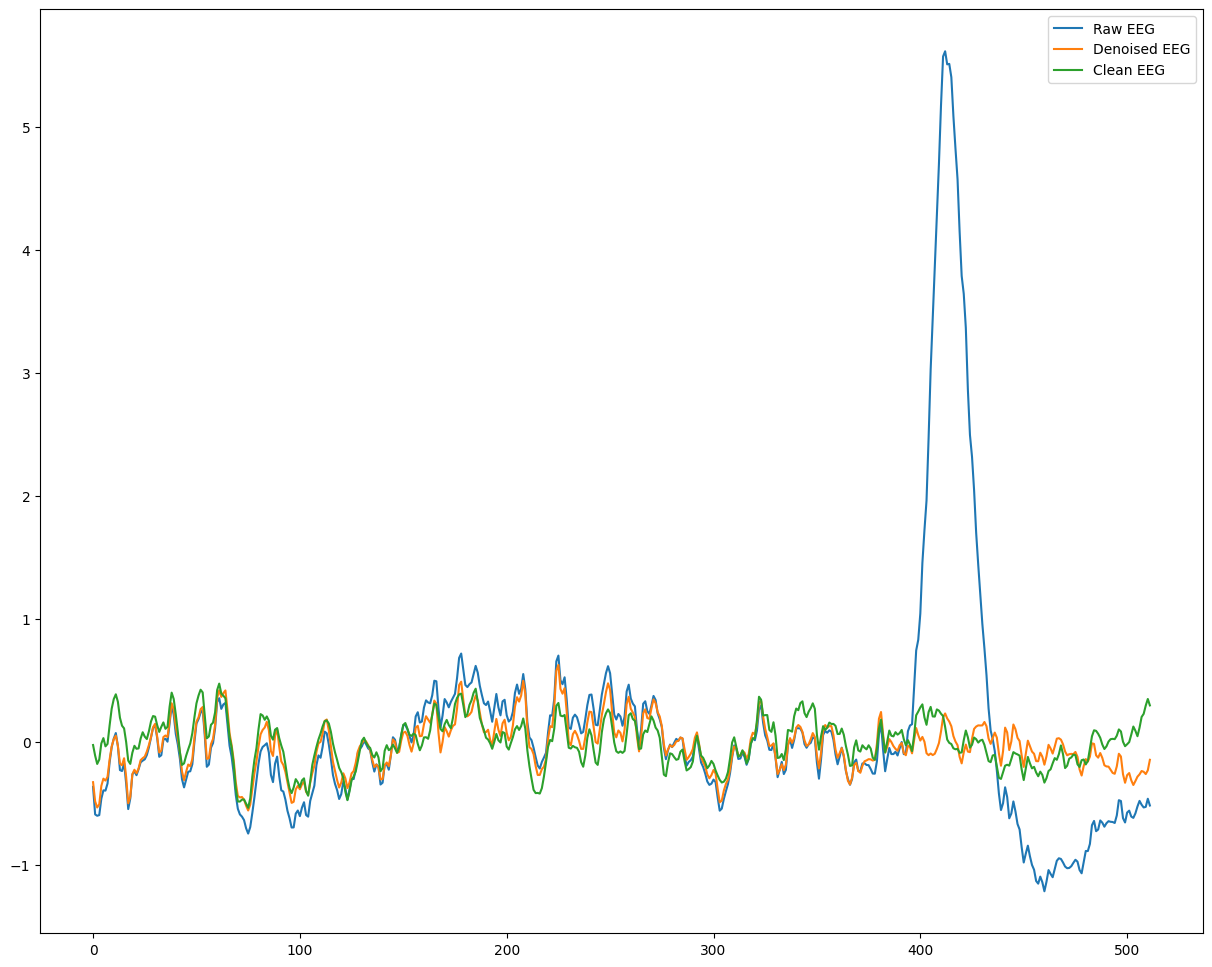

In [4]:
model_name = 'mysetp1'
index = 13
plt.figure(figsize=(15,12))
test_input = np.load('EEG_cnn/denoiseNET_dataset/test_input.npy')
test_input = test_input[index]
test_output = np.load('EEG_cnn/denoiseNET_dataset/test_output.npy')
test_output = test_output[index]

test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_input = torch.unsqueeze(test_input, 0)
test_output = torch.unsqueeze(test_output, 0)

test_torch_dataset = Data.TensorDataset(test_input)

print("torch.cuda.is_available() = ", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = deepCNN()
model.to(device)

if os.path.exists('EEG_cnn/checkpoint/' + model_name + '.pkl'):
    print('load model')
    model.load_state_dict(torch.load('EEG_cnn/checkpoint/' + model_name + '.pkl'))


test_input = test_input.float().to(device)

extracted_signal = model(test_input, 0) 
extracted_artifact = model(test_input, 1)  


test_input_value = test_input.cpu()
test_input_value = test_input_value.detach().numpy()
test_input_value = test_input_value[0]

test_output_value = test_output.cpu()
test_output_value = test_output_value.detach().numpy()
test_output_value = test_output_value[0]

extracted_signal_value = extracted_signal.cpu()
extracted_signal_value = extracted_signal_value.detach().numpy()
extracted_signal_value = extracted_signal_value[0]

extracted_artifact_value = extracted_artifact.cpu()
extracted_artifact_value = extracted_artifact_value.detach().numpy()
extracted_artifact_value = extracted_artifact_value[0]

l0, = plt.plot(test_input_value)
l1, = plt.plot(extracted_signal_value)
#l2, = plt.plot(extracted_artifact_value)
l3, = plt.plot(test_output_value)
# plt.legend([l0, l1, l2, l3], ['Raw EEG', 'Denoised EEG', 'Extracted Artifact', 'Clean EEG'], loc='upper right')
plt.legend([l0, l1, l3], ['Raw EEG', 'Denoised EEG', 'Clean EEG'], loc='upper right')

plt.show()





